In [24]:
import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx

In [25]:
PLT_CELL = 3.5

In [26]:
np.random.seed(0)

A_true = np.zeros((8, 8))
d = A_true.shape[0]
N = 100
sigma = np.eye(d)*0.05

for i in range(A_true.shape[0]):
    A_true[i, (i+1) % d] = 1
A_true[-1, 0] = -1
A_true = 1.25*(A_true - np.eye(d))
    
T = 10
t1 = 10
dt = 0.01
ts = np.linspace(0, t1, T)

x0 = (np.arange(d) == 0) * 0.25

def simulate(A, N, x_init = None):
    xs = []
    for i in range(T):
        x = np.random.randn(N, d)*0.05 + x0 if x_init is None else x_init
        t = 0
        while t < ts[i]:
            x += x @ A * dt + np.random.randn(N, d) @ sigma * dt**0.5
            t += dt
        xs.append(x)
    return np.stack(xs)

# knockouts
kos = []
Ms = [np.ones((d, d), ), ]
ko_label = ["wt", ]
for i in kos:
    M = np.ones((d, d))
    M[:, i] = 0
    Ms.append(M)
    ko_label.append(str(i))
kos = [None, ] + [str(i) for i in kos]

xs = []
for M in Ms:
    xs.append(simulate(A_true * M, int(N)))
xs = np.stack(xs)

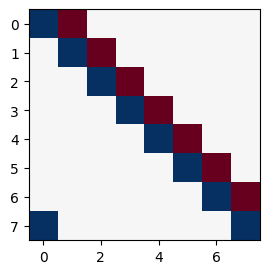

In [27]:
plt.figure(figsize = (3, 3))
plt.imshow(A_true, cmap = "RdBu_r", vmin = -1, vmax = 1)

In [28]:
A_true

array([[-1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25],
       [-1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25]])

In [29]:
np.real(np.linalg.eigvals(A_true))

array([-2.40484942, -2.40484942, -1.72835429, -1.72835429, -0.77164571,
       -0.77164571, -0.09515058, -0.09515058])

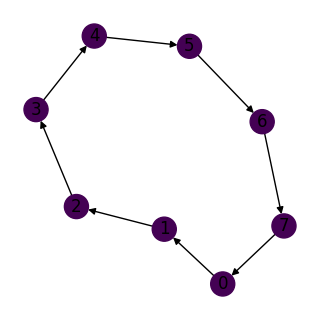

In [30]:
import networkx as nx
_A = A_true.copy()
np.fill_diagonal(_A, 0)
g = nx.DiGraph(np.abs(_A))
centralities = nx.centrality.eigenvector_centrality(g)
plt.figure(figsize = (3, 3))
nx.draw(g, with_labels = True, node_color = [centralities[x] for x in g.nodes])

In [31]:
import sklearn as sk
from sklearn import decomposition
pca_op = sk.decomposition.PCA(n_components = d)
pca_op.fit(xs.reshape(-1, d))
ys = pca_op.transform(xs.reshape(-1, d)).reshape(xs.shape)

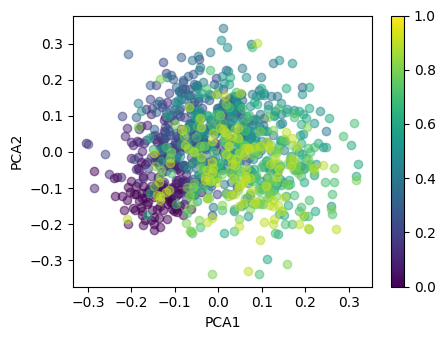

In [32]:
from matplotlib import cm, colors
norm = colors.Normalize(vmin = 0, vmax = T)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize = (4/3*PLT_CELL, PLT_CELL))
for j in range(T):
    plt.scatter(ys[0, j, :, 0], ys[0, j, :, 1], alpha = 0.5, color = m.to_rgba(j))
cb = plt.colorbar()
cb.solids.set(alpha=1)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.tight_layout()
plt.savefig("../figures/OU_8D_snapshots.pdf")

In [95]:
import sys
sys.path.append("../src/")
import importlib
import rf
importlib.reload(rf)
import torch

In [96]:
adatas = [ad.AnnData(np.vstack(xs[i, ...]), {"t" : np.hstack([np.repeat(i, x.shape[0]) for (i, x) in enumerate(xs[i, ...])])}) for i in range(xs.shape[0])]

In [97]:
centralities = pd.Series(centralities)
ko_genes = centralities.index[np.argsort(np.array(centralities))[::-1]][:0]

ko_idx = [np.where(np.array(kos) == None)[0][0], ]
for x in ko_genes:
    try:
        ko_idx.append(np.where(np.array(kos) == str(x))[0][0])
    except:
        pass
[kos[i] for i in ko_idx]

[None]

In [115]:
options = {
    "lr" : 0.25, 
    "reg_sinkhorn" : 0.1,
    "reg_A" : 0.00001, 
    "reg_A_elastic" : 0, 
    "iter" : 1000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam
}
estim_alt = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = True,
                           optimizer = options["optimizer"])
estim_alt.fit(print_iter=100, alg = "alternating");

/home/groups/xiaojie/zys/temporal_perturb/notebooks/../src/rf.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.b, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = -0.021845360880974142, L = -0.02194536088097414, R = 10.0
iteration 100, loss = -0.028927567905428785, L = -0.029641708877258446, R = 71.41409718296588
iteration 200, loss = -0.029335673047174556, L = -0.030186364358382203, R = 85.0691311207648
iteration 300, loss = -0.029501126670991907, L = -0.03038540727764373, R = 88.42806066518244
iteration 400, loss = -0.029581159780279254, L = -0.030474540091821285, R = 89.33803115420304
iteration 500, loss = -0.029629005433862866, L = -0.030524196847289044, R = 89.51914134261771
iteration 600, loss = -0.029651505618938142, L = -0.030555560155505004, R = 90.40545365668629
iteration 700, loss = -0.02966437877077952, L = -0.030571330603025432, R = 90.69518322459109
iteration 800, loss = -0.02966938073959581, L = -0.03058742400364291, R = 91.80432640471008
iteration 900, loss = -0.029673861679898418, L = -0.03059885478632492, R = 92.49931064265027


In [92]:
estim_fixed = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = True,
                           optimizer = options["optimizer"])
estim_fixed.fit(print_iter=100, alg = "fixed");

/home/groups/xiaojie/zys/temporal_perturb/notebooks/../src/rf.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = -0.0189214887515851, L = -0.0189214887515851, R = 0.0
iteration 100, loss = -0.027605209330063378, L = -0.028278027009115667, R = 67.28176790522889
iteration 200, loss = -0.02763113120030182, L = -0.028345683160215424, R = 71.45519599136055
iteration 300, loss = -0.027634449949991355, L = -0.028356428007601416, R = 72.19780576100595
iteration 400, loss = -0.027634639244590472, L = -0.028358578133210903, R = 72.39388886204308
iteration 500, loss = -0.027633916108270713, L = -0.028362552820572023, R = 72.86367123013076
iteration 600, loss = -0.027634424057994916, L = -0.028361125887454555, R = 72.67018294596399
iteration 700, loss = -0.027633222535848514, L = -0.028356242881787105, R = 72.30203459385923
iteration 800, loss = -0.027632224334049865, L = -0.028357507311824046, R = 72.52829777741832
iteration 900, loss = -0.02763479788081121, L = -0.028360909825553653, R = 72.61119447424403


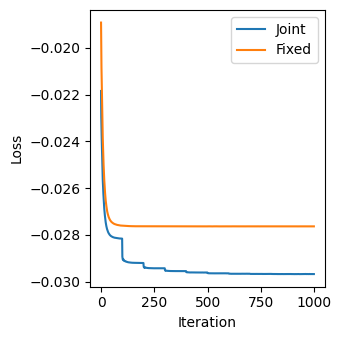

In [116]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
plt.plot(estim_alt.trace, label = "Joint")
plt.plot(estim_fixed.trace, label = "Fixed")
plt.legend()
plt.xlabel("Iteration"); plt.ylabel("Loss")
plt.tight_layout()
# plt.savefig("../figures/OU_8D_fitting.pdf")

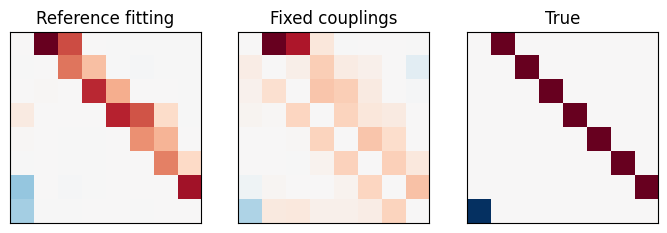

In [117]:
plt.figure(figsize = (2*PLT_CELL, PLT_CELL*2/3))
plt.subplot(1, 3, 1)
plt.imshow(estim_alt.A, vmin = -10, vmax = 10, cmap = "RdBu_r")
plt.title("Reference fitting")
plt.gca().xaxis.set_visible(False); plt.gca().yaxis.set_visible(False)
plt.subplot(1, 3, 2)
plt.imshow(estim_fixed.A, vmin = -10, vmax = 10, cmap = "RdBu_r")
plt.title("Fixed couplings")
plt.gca().xaxis.set_visible(False); plt.gca().yaxis.set_visible(False)
plt.subplot(1, 3, 3)
plt.imshow(A_true * (1 - np.eye(A_true.shape[0])), cmap = "RdBu_r", vmin = -1, vmax = 1)
plt.title("True"); 
plt.gca().xaxis.set_visible(False); plt.gca().yaxis.set_visible(False)
plt.tight_layout()
# plt.savefig("../figures/OU_8D_nets.pdf")

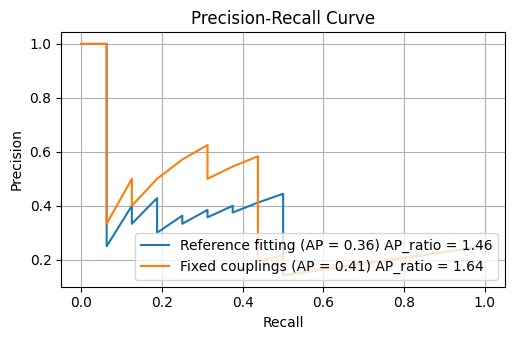

In [90]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = np.abs(np.sign(A_true).astype(int).flatten())
ys["Reference fitting"] = np.abs(estim_alt.A.flatten())
ys["Fixed couplings"] = np.abs(estim_fixed.A.flatten())

plt.figure(figsize=(1.5*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AP = {avg_prec:.2f}) AP_ratio = {avg_prec / y_true.mean():.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc = 'lower right')
plt.grid(True)
plt.tight_layout()
# plt.savefig("../figures/OU_8D_precision.pdf")

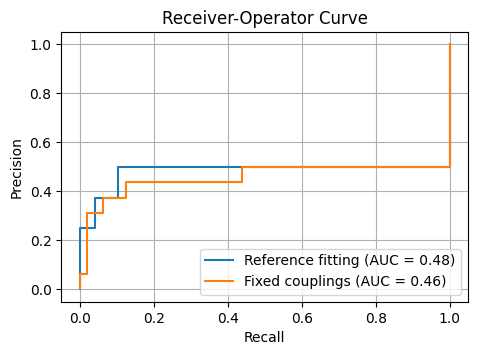

In [85]:
plt.figure(figsize=(1.5*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    fpr, tpr, thresh = roc_curve(y_true, y)
    auc = roc_auc_score(y_true, y)
    plt.plot(fpr, tpr, label=f'{k} (AUC = {auc:.2f})',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Receiver-Operator Curve')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [254]:
T = 10

In [255]:
ys = [estim_alt.Xs[0][i] @ estim_alt.M_pca for i in range(T)]

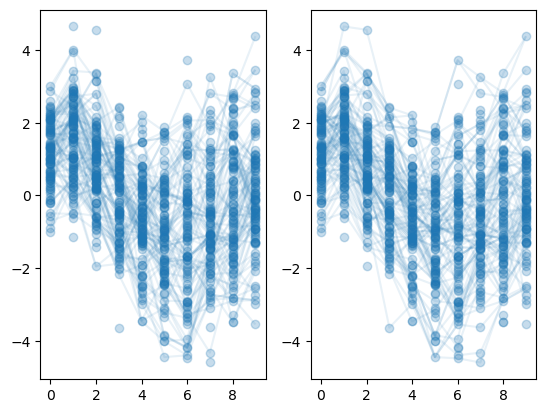

In [256]:
import itertools
from matplotlib.collections import LineCollection
N_paths = 100
dim = 1

x = np.hstack([ys[i][:, dim] for i in range(len(ys))])
t = np.hstack([np.repeat(i, ys[0].shape[0]) for i in range(len(ys))])

plt.subplot(1, 2, 1)
Ts = estim_alt.Ts[0]
plt.scatter(t, x, alpha = 0.25)
lc = []
np.random.seed(0)
for _ in range(N_paths):
    seq = [np.random.randint(Ts[0].shape[0]), ]
    for T in Ts:
        ps = T[seq[-1], :]
        seq.append(np.random.choice(range(T.shape[1]), p = ps / ps.sum()))
    lc.append([(l, ys[l][seq[l], dim].item()) for l in range(len(Ts)+1)])
lc = LineCollection(lc, alpha = 0.1)
plt.gca().add_collection(lc)
plt.subplot(1, 2, 2)
Ts = estim_fixed.Ts[0]
plt.scatter(t, x, alpha = 0.25)
lc = []
np.random.seed(0)
for _ in range(N_paths):
    seq = [np.random.randint(Ts[0].shape[0]), ]
    for T in Ts:
        ps = T[seq[-1], :]
        seq.append(np.random.choice(range(T.shape[1]), p = ps / ps.sum()))
    lc.append([(l, ys[l][seq[l], dim].item()) for l in range(len(Ts)+1)])
lc = LineCollection(lc, alpha = 0.1)
plt.gca().add_collection(lc)

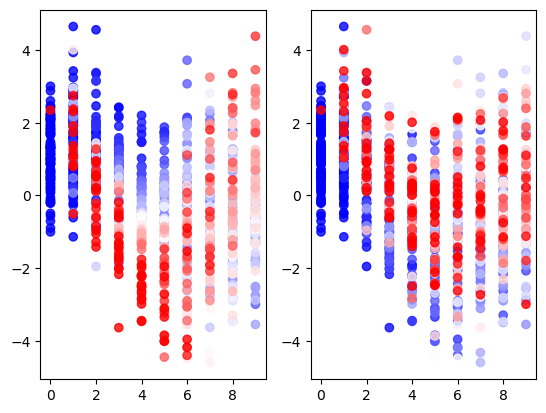

In [257]:
i0 = 0
plt.subplot(1, 2, 1)
Ts = estim_alt.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for T in Ts:
    ps.append((T / T.sum(0)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(t[ord], x[ord], alpha = 0.8, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")
plt.subplot(1, 2, 2)
Ts = estim_fixed.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for T in Ts:
    ps.append((T / T.sum(0)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(t[ord], x[ord], alpha = 0.8, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")

In [258]:
x = np.vstack([ys[i] for i in range(len(ys))])
t = np.hstack([np.repeat(i, ys[0].shape[0]) for i in range(len(ys))])

In [277]:
x[np.where(ps == 1.0)[0][0], :]

array([-1.40518564,  2.35059961,  2.25425375, -0.63636593,  1.71953902,
        0.72384652,  1.15170743,  0.45229535])

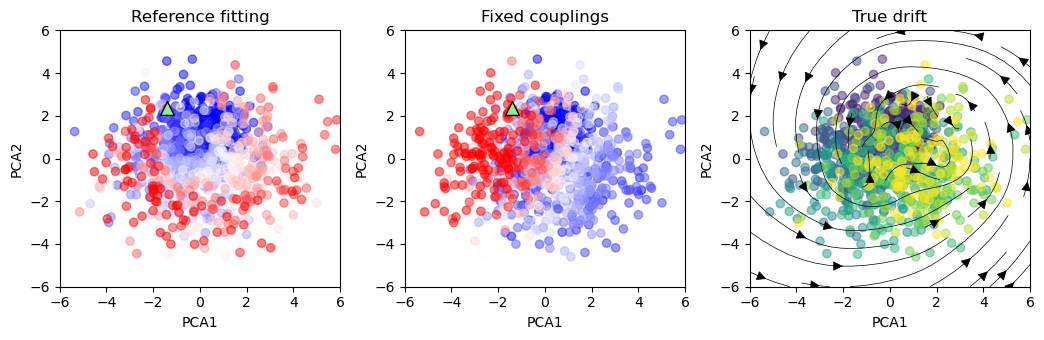

In [289]:
i0 = 0
plt.figure(figsize = (PLT_CELL*3, PLT_CELL))
plt.subplot(1, 3, 1)
Ts = estim_alt.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for _T in Ts:
    ps.append((_T / _T.sum(-1)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(x[ord, 0], x[ord, 1], alpha = 0.5, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")
x0 = x[np.where(ps == 1.0)[0][0], :][None, :]
plt.scatter(x0[:, 0], x0[:, 1], color = 'lightgreen', marker = "^", s = 100, edgecolors='k')
plt.ylim(-6, 6); plt.xlim(-6, 6)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("Reference fitting")
plt.subplot(1, 3, 2)
Ts = estim_fixed.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for _T in Ts:
    ps.append((_T / _T.sum(-1)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(x[ord, 0], x[ord, 1], alpha = 0.5, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")
plt.scatter(x0[:, 0], x0[:, 1], color = 'lightgreen', marker = "^", s = 100, edgecolors='k')
plt.ylim(-6, 6); plt.xlim(-6, 6)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("Fixed couplings")
plt.subplot(1, 3, 3)
v = xs[0, ...].reshape(-1, d) @ A_true
v = estim_alt.scaler.transform(v) @ estim_alt.M_pca.numpy()
plt.scatter(x[:, 0], x[:, 1], c = t, alpha = 0.5)
# plt.quiver(x[:, 0], x[:, 1], v[:, 0], v[:, 1], scale_units = 'xy', scale = 4)
interp_x = sp.interpolate.Rbf(x[:, 0], x[:, 1], v[:, 0])
interp_y = sp.interpolate.Rbf(x[:, 0], x[:, 1], v[:, 1])
X, Y = np.meshgrid(np.linspace(-6, 6, 10),
                   np.linspace(-6, 6, 10))
U, V = interp_x(X, Y), interp_y(X, Y)
plt.streamplot(X, Y, U, V, density = 0.5, color = 'k', arrowsize = 1.5, linewidth = 0.5)
plt.ylim(-6, 6); plt.xlim(-6, 6)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("True drift")
plt.tight_layout()
plt.savefig("../figures/OU_8D_drifts.pdf")